In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

%matplotlib inline

만약 데이터가 선형적인 관계를 가지고 있지 않다면?

## 선형 기저함수 모델 (Linear Basis Function Models)

비선형데이터를 선형함수로 모델링하는 한가지 방법은 기저함수(Basis Function)을 사용하는 것이다.  
예를 들어 다음과 같은 선형 함수를 사용한다고 하자.
$$ y = a_0 + a_1x_1 + a_2x_2 + a_3x_3 \cdots $$

여기서 $x_1, x_2, x_3$ 등을 1차원 x로부터 생성할 수 있다($x_n = f_n(x)$).  
$f_n$을 기저 함수(Basis Function)이라고 부른다.


만약 $f_n(x) = x^n$ 이라는 기저 함수를 사용하면 최종적인 모델은 다음과 같을 것이다.
$$ y = a_0 + a_1x + a_2x^2 + a_3x^3 \cdots $$

이 모델은 여전히 계수($a_n$)에 관해서는 선형함수임을 기억하자.  
따라서, 1차원 변수인 x를 기저함수를 통해 다차원으로 확장시킴으로써 우리는 여전히 선형 모델(Linear Regression)을 사용할 수 있게 된다.

### 다항 기저함수 (Polynomial Basis Functions)

$f_n(x) = x^n$형태의 함수를 다항 기저함수(Polynomial Basis Functions)라고 부른다.  
Scikit-Learn은 ```PolynomialFeatures```이라는 Transformer를 이미 포함하고 있다.

In [2]:
from sklearn.preprocessing import PolynomialFeatures
x    = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

PolynomialFeatures가 1차원 array를 3차원 array로 변환한 것을 볼 수 있다. 이렇게 변환된 데이터를 생성하고 모델링해보자.

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
poly_model = make_pipeline(PolynomialFeatures(7),
                         LinearRegression())

다차원 변환을 사용하면 복잡한 데이터를 모델링할 수 있게 된다.  
예를 들어 Sine 함수를 사용해서 데이터를 생성하고 모델링 해보자.

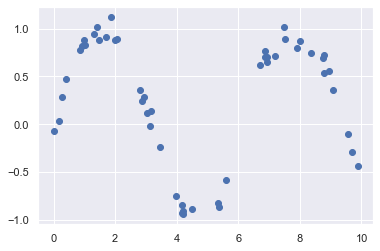

In [4]:
rng = np.random.RandomState(1)
x   = 10 * rng.rand(50)
y   = np.sin(x) + 0.1 * rng.randn(50) ## Sine 함수에 노이즈 더함

plt.scatter(x, y)
plt.show()

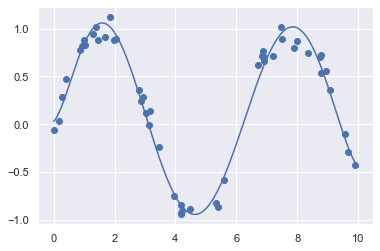

In [5]:
poly_model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.show()

### 가우시안 기저함수 (Gaussian Basis Functions)

다항 기저함수 외에 다른 기저함수를 사용해보자.  
가우시안 기저함수는 다음과 같이 정의된다.
$$ exp\{-{(x - \mu_j)^2 \over 2s^2}\} $$

$\mu_j$는 함수의 위치, $s$는 폭을 결정한다. (고정값)  
주어진 데이터를 여러 개의 가우시안 기저함수들의 합으로 표현하려고 시도할 수 있다.

<img src = "./images/Gausian_Basis_Function.png" width="500">

그래프 아래 회색 부분은 다수의 가우시안 기저함수들을 보여주고 있다.  
이 기저함수들의 합은 데이터를 가로지르는 매끈한 곡선이 된다.  

가우시안 기저 함수는 Scikit-Learn에 포함되어 있지 않지만, 어렵지 않게 구현할 수 있다.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin) :
    """Uniformly spaced Gaussian featues for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0) : 
        self.N = N
        self.width_factor = width_factor
        
    @staticmethod
    def _gauss_basis(x, y, width, axis=None) :
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    

    def fit(self, X, y=None) :
        # Create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_   = self.width_factor * (self.centers_[1] - self.centers_)
        return self
    
    def transform(self, X) :
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

<ipython-input-6-7a57ea2fbcc6>:12: RuntimeWarning: divide by zero encountered in true_divide
  arg = (x - y) / width
<ipython-input-6-7a57ea2fbcc6>:12: RuntimeWarning: divide by zero encountered in true_divide
  arg = (x - y) / width


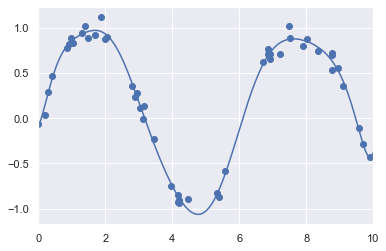

In [7]:
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10)
plt.show()

## 규제화 (Regularization)

기저함수를 사용함으로써 복잡한 데이터를 모델링할 수 있게 되었지만 조심하지 않는다면 over-fitting이라는 다른 심각한 문제를 만날 수 있다!   
예를 들어, 너무 많은 개수의 가우시안 기저함수를 사용하게 되면, 다음과 같이 될 수 있다.

<ipython-input-6-7a57ea2fbcc6>:12: RuntimeWarning: divide by zero encountered in true_divide
  arg = (x - y) / width
<ipython-input-6-7a57ea2fbcc6>:12: RuntimeWarning: divide by zero encountered in true_divide
  arg = (x - y) / width


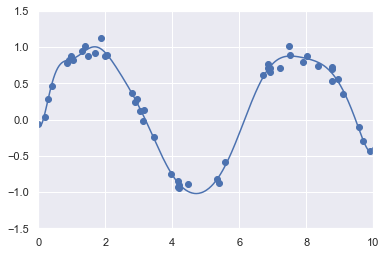

In [8]:
gauss_model = make_pipeline(GaussianFeatures(30),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)
plt.show()

이 예제에서는 30개의 기저함수가 사용되었는데 모델이 필요이상으로 flexible해져서 데이터가 없는 곳에서는 극단적인 값을 가지는 것을 볼 수 있다.  
기저함수의 계수들은 다음과 같이 확인할 수 있다.

In [9]:
def basis_plot(model, title=None) : 
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title :
        ax[0].set_title(title)
        
    ax[1].plot(model.steps[0][1].centers_,
              model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
             xlim=(0,10))
    plt.show()

<ipython-input-6-7a57ea2fbcc6>:12: RuntimeWarning: divide by zero encountered in true_divide
  arg = (x - y) / width
<ipython-input-6-7a57ea2fbcc6>:12: RuntimeWarning: divide by zero encountered in true_divide
  arg = (x - y) / width


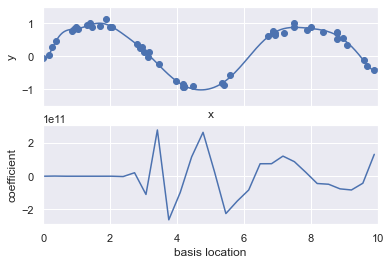

In [10]:
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

위 두번째 그래프는 각각의 가우시안 기저함수의 크기(계수값)을 보여주고 있다.  
Over-fitting이 일어나는 영역에서는 인접한 기저함수들의 값이 극단으로 가면서 서로 상쇄하는 현상이 일어난다.  
따라서 큰 계수값에 대해 Penalty를 부여해서 Over-fitting을 어느정도 극복할 수 있을 것이다.  
이러한 Penalty를 Regularization이라 부른다.

### Ridge Regression ($L_2$ Regularization)

가장 자주 쓰이는 형태의 Regularization은 Ridge Regression($L_2$ Regularization)이고 다음과 같이 정의된다.
$$ P = \alpha \sum_{n=1}^N\theta_n^2$$

여기서 $\alpha$는 Regularization의 강도를 조절하는 파라미터이다. 이 형태의 Regularization은 Scikit-Learn의 ```Ridge``` Estimator에서 사용된다

$\alpha$값이 0에 가까워질수록 일반적인 선형회귀모델이 되고, $\alpha$값이 무한대로 증가하면 데이터는 모델에 영향을 주지 않게 된다.

<ipython-input-6-7a57ea2fbcc6>:12: RuntimeWarning: divide by zero encountered in true_divide
  arg = (x - y) / width
<ipython-input-6-7a57ea2fbcc6>:12: RuntimeWarning: divide by zero encountered in true_divide
  arg = (x - y) / width


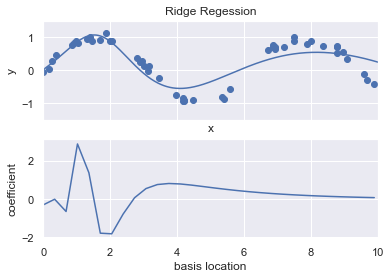

In [11]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regession')

### Lasso Regression($L_1$ Regularization)

또 하나 자주 쓰이는 Regularization방법은 계수들의 절댓값의 합을 제한하는 것이다.
$$ P = \alpha \sum_{n=1}^N|\theta_n|$$

뒤에서 자세히 다루겠지만 이 방법은 sparse한 모델을 생성하게 된다.(많은 계수들이 0이 됨)

위에서 볼 수 있듯이 대부분의 계수값들이 0이 된다. Ridge Regression과 마찬가지로 $\alpha$값으로 Regularization의 강도를 조절할 수 있다.

<ipython-input-6-7a57ea2fbcc6>:12: RuntimeWarning: divide by zero encountered in true_divide
  arg = (x - y) / width
/Users/yuseon/ys/KDT_AI/W6_Introduction_to_Machine_Learning/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33365443407174267, tolerance: 0.002065280097246271
  model = cd_fast.enet_coordinate_descent(
<ipython-input-6-7a57ea2fbcc6>:12: RuntimeWarning: divide by zero encountered in true_divide
  arg = (x - y) / width


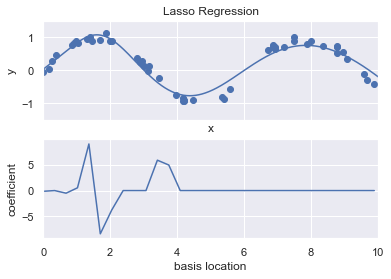

In [12]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

### SGD (Stochastic Gradient Descent)

<ipython-input-6-7a57ea2fbcc6>:12: RuntimeWarning: divide by zero encountered in true_divide
  arg = (x - y) / width
<ipython-input-6-7a57ea2fbcc6>:12: RuntimeWarning: divide by zero encountered in true_divide
  arg = (x - y) / width


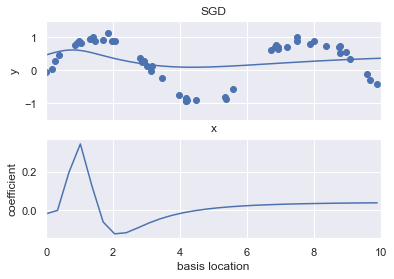

In [13]:
from sklearn.linear_model import SGDRegressor
model = make_pipeline(GaussianFeatures(30),
                     SGDRegressor(max_iter=100000, tol=1e-8, alpha=0))
basis_plot(model, title='SGD')